In [1]:
import os
import random
import logging
from copy import deepcopy
from collections import defaultdict
from matplotlib import pyplot as plt

import cv2
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

from isegm.utils.log import logger, TqdmToLogger, SummaryWriterAvg
from isegm.utils.vis import draw_probmap, draw_points, add_tag
from isegm.utils.misc import save_checkpoint
from isegm.utils.serialization import get_config_repr
from isegm.utils.distributed import get_dp_wrapper, get_sampler, reduce_loss_dict
from torch.cuda.amp import autocast as autocast, GradScaler

from isegm.utils.exp_imports.default import * 

MODEL_NAME = "lidc_hrnet32"

from isegm.data.compose import ComposeDataset, ProportionalComposeDataset
import torch.nn as nn
from isegm.data.aligned_augmentation import AlignedAugmentator
# from isegm.engine.focalclick_trainer import ISTrainer

from isegm.data.compose import ComposeDataset, ProportionalComposeDataset
import torch.nn as nn
from isegm.data.aligned_augmentation import AlignedAugmentator
# from isegm.engine.focalclick_trainer import ISTrainer
from isegm.data.preprocess import Preprocessor
from isegm.utils import exp
from isegm.inference import utils

cfg = exp.load_config_file('config.yml', return_edict=True)

In [4]:
def visualise_batch(batch):
    images, masks = batch['images'], batch['instances']
    fig, ax = plt.subplots(5, 2, figsize=(5, 3*len(images)))
    plt.close()
    
    i = 0
    for image, mask in zip(images, masks):
        image = image.numpy()[0, :, :]
        mask = mask.numpy()[0, :, :]
        ax[i,0].imshow(image, cmap='gray')
        ax[i,1].imshow(mask)
        ax[i,0].axis('off')
        ax[i,1].axis('off')
        i += 1
        print(i)
    return fig

In [23]:
from isegm.data.augmentations import AugmentationsProvider

points_sampler = MultiPointSampler(
        24,
        prob_gamma=0.80,
        merge_objects_prob=0.15,
        max_num_merged_objects=2,
        use_hierarchy=False,
        first_click_center=True,
    )

preprocess_cfg = {
    'enhancements': {
        },
    'normalize': False,
    'windowing': {
        'enabled': True,
        'min': -900,
        'max': 600,
    },
    'convert_to_rgb': False
}

preprocessor = Preprocessor(preprocess_cfg)

aug_conf = edict({
    # 'augmentation_type': 'focalclick_standard',
    # 'augmentation_type': 'ritm_standard',
    'augmentation_type': 'target_crop',
    # 'augmentation_type': 'none',
    'target_crop_augmentation': {
        'crop_size': 256,
        'crop_probability':0.8
    },
    'dataset': {
        'val': 'LIDC_2D_VAL'
    },
    'data_paths': cfg
})
model_conf = edict({
    'crop_size': (256,256)
})
aug_provider = AugmentationsProvider()

dataset = utils.get_dataset('LIDC_2D_VAL', cfg, preprocessor=preprocessor)
dataset.augmentator = aug_provider.get_augmentator(aug_conf, model_conf)

dataset.points_sampler = points_sampler
loader = DataLoader(
            dataset,
            5,
            sampler=get_sampler(dataset, shuffle=False, distributed=False),
            drop_last=True,
            pin_memory=True,
            num_workers=0,
        )
loader_iter = iter(loader)
batch = next(loader_iter)
img, mask = batch['images'][0,0], batch['instances'][0][0]
# visualise_batch(batch)

Target crop bounds for LIDC_2D_VAL dataset: (0.064, 0.196)
Target crop bounds for LIDC_2D_VAL dataset: (0.064, 0.196)
Target crop bounds for LIDC_2D_VAL dataset: (0.064, 0.196)
Applied target crop augmentation for train dataset. Input size: (256, 256)
Applied target crop augmentation for train dataset. Input size: (256, 256)
Applied target crop augmentation for train dataset. Input size: (256, 256)


(-0.5, 255.5, 255.5, -0.5)

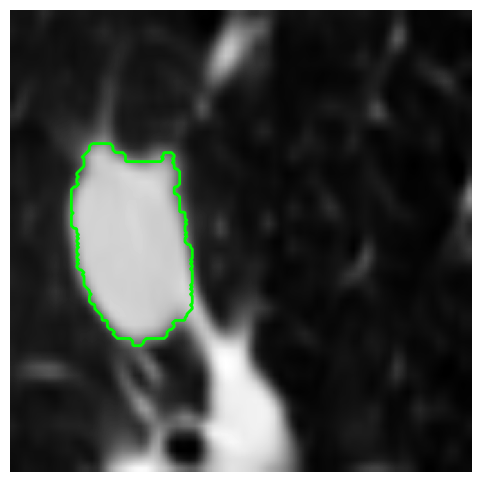

In [24]:
fig, ax = plt.subplots(1,1, figsize=(6,6), frameon=False)
ax.imshow(img, cmap='gray')
ax.contour(mask, levels=[0.5], colors='lime', linewidths=2)
ax.axis('off')

In [21]:
def measure_object_size(datasets):
    area_sizes = []
    for dataset_name in datasets:
        dataset = utils.get_dataset(dataset_name, cfg, preprocessor=preprocessor)
        for i in range(len(dataset)):
            sample = dataset.get_sample(i)
            gt_mask = sample.gt_mask
            connected_components = cv2.connectedComponentsWithStats(gt_mask.astype(np.uint8), connectivity=4)
            for connected_component in connected_components[2][1:]:
                area_sizes.append(connected_component[4])
    median_size = np.median(area_sizes)
    below_900 = len([size for size in area_sizes if size <= 900])
    
    return median_size, below_900 / len(area_sizes)
    
# measure_object_size(dataset)

In [24]:
# datasets = ['LIDC_2D_VAL', 'KITS23_2D_TUMOURS_VAL', 'LITS_2D_VAL', 'MD_PANC_2D_VAL', 'COMBINED_2D_VAL']
datasets = ['LIDC_2D', 'KITS23_2D_TUMOURS', 'LITS_2D', 'MD_PANC_2D', 'COMBINED_2D']
median_size, below_900 = measure_object_size(datasets)
print(f'Median size: {median_size}, below 900: {below_900}')

Median size: 460.0, below 900: 0.6977025392986699


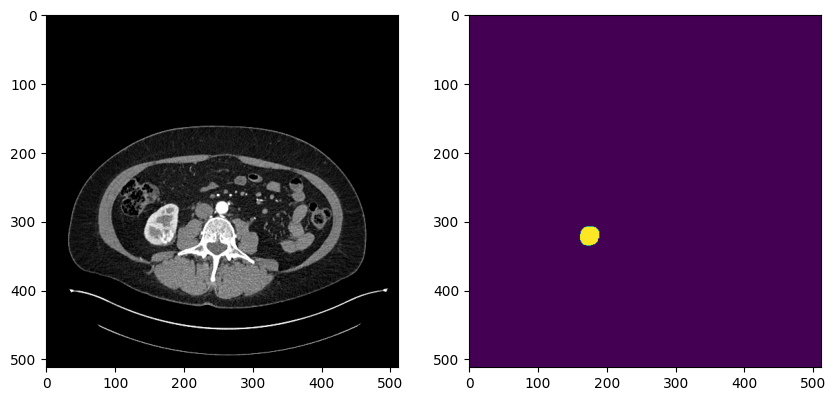

In [18]:
sample = dataset.get_sample(0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample.image[:,:,0], cmap='gray')
ax[1].imshow(sample.gt_mask)

In [8]:
import pickle
# read missing mask list
with open('empty_mask_sample_paths.pkl', 'rb') as f:
    missing_masks = pickle.load(f)

In [ ]:
missing_masks

('/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/KITS23-2D-TUMOURS/train/slices/case_00419_53.npy',
 '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/KITS23-2D-TUMOURS/train/slice_annotations/case_00419_53.npy')

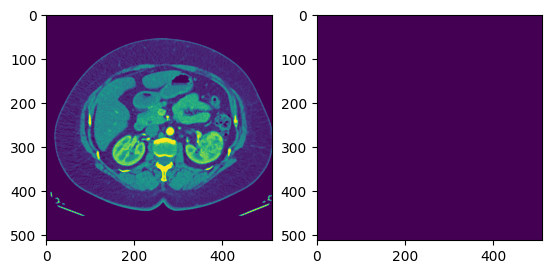

In [20]:
sample = dataset.get_sample(226)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample.image[:, :, 0])
ax[1].imshow(sample.gt_mask)
dataset.get_sample_paths(226)

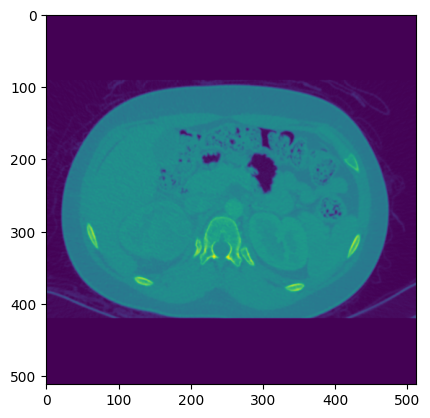

In [19]:
plt.imshow(np.load('/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/KITS23-2D-TUMOURS/slices/case_00160_101.npy'))

In [33]:
import nibabel as nib
scan = nib.load('/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/Raw datasets/kits23/dataset/case_00160/imaging.nii.gz')
scan.get_fdata().shape

(252, 512, 796)

In [34]:
scan = nib.load('/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/Raw datasets/kits23/dataset/case_00419/imaging.nii.gz')
scan.get_fdata().shape

(81, 512, 651)

In [18]:
for i in range(len(dataset)):
    sample = dataset.get_sample(i)
    if sample.image.shape != (512, 512, 3):
        print(i, sample.image.shape)

In [36]:
dataset = utils.get_dataset('KITS23_2D_TUMOURS_FULL', cfg, preprocessor=preprocessor)
dataset.points_sampler = points_sampler

In [ ]:
for i in range(len(dataset)):
    sample = dataset.get_sample(i)
    if sample.image.shape != (512, 512, 3):
        print(i, sample.image.shape, dataset.get_sample_paths(i)[0])

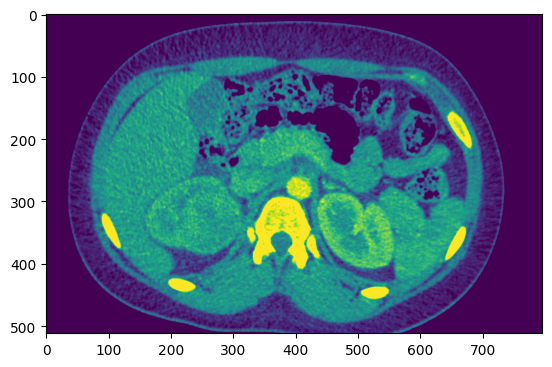

In [40]:
sample = dataset.get_sample(3541)
plt.imshow(sample.image[:,:,0])

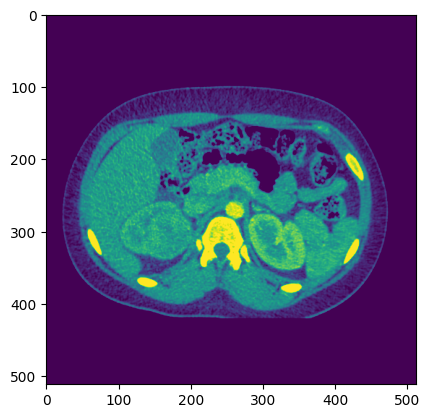

In [48]:
import numpy as np
from skimage.transform import resize

original_array = sample.image[:,:,0]

min_value = np.min(original_array)
max_dimension = max(original_array.shape[0], original_array.shape[1])
square_array = np.full((max_dimension, max_dimension), fill_value=min_value)
offset_x = (max_dimension - original_array.shape[1]) // 2
offset_y = (max_dimension - original_array.shape[0]) // 2
square_array[offset_y:offset_y+original_array.shape[0], offset_x:offset_x+original_array.shape[1]] = original_array

resized_array = resize(square_array, (512, 512), anti_aliasing=True)

plt.imshow(resized_array)

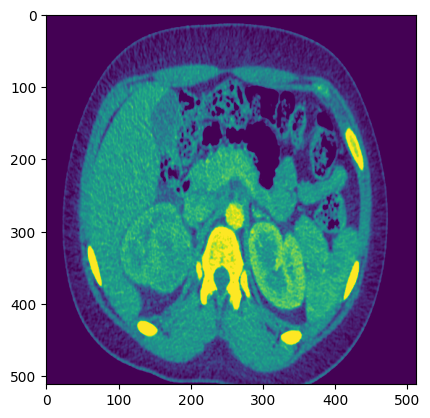

In [44]:
resized_image = torch.nn.functional.interpolate(
    torch.tensor(sample.image[:,:,0]).unsqueeze(0).unsqueeze(0),
    size=(512, 512),
    mode='bilinear',
    align_corners=True,
).squeeze(0).squeeze(0)
plt.imshow(resized_image)

In [4]:
loader = DataLoader(
            dataset,
            40,
            sampler=get_sampler(dataset, shuffle=False, distributed=False),
            drop_last=True,
            pin_memory=True,
            num_workers=0,
        )
loader_iter = iter(loader)
batch = next(loader_iter)
# visualise_batch(batch)

In [31]:
from isegm.data.augmentations import AugmentationsProvider

points_sampler = MultiPointSampler(
        24,
        prob_gamma=0.80,
        merge_objects_prob=0.15,
        max_num_merged_objects=2,
        use_hierarchy=False,
        first_click_center=True,
    )

preprocess_cfg = {
    'enhancements': {
        },
    'normalize': False,
    'windowing': {
        'enabled': True,
        'min': -900,
        'max': 600,
    },
    'convert_to_rgb': False
}

preprocessor = Preprocessor(preprocess_cfg)

aug_conf = edict( {
    'augmentation_type': 'focalclick_standard'
})
model_conf = edict({
    'crop_size': {
        'height': 256,
        'width': 256
    }
})
aug_provider = AugmentationsProvider()

dataset = utils.get_dataset('LIDC_2D_VAL', cfg, preprocessor=preprocessor)


dataset.augmentator = aug_provider.get_augmentator(aug_conf, model_conf)
dataset.points_sampler = points_sampler
loader = DataLoader(
            dataset,
            5,
            sampler=get_sampler(dataset, shuffle=False, distributed=False),
            drop_last=True,
            pin_memory=True,
            num_workers=0,
        )
loader_iter = iter(loader)
batch = next(loader_iter)
img, mask = batch['images'][0,0], batch['instances'][0]
# visualise_batch(batch)

Applied FocalClick standard augmentations for train dataset. Input size: {'height': 256, 'width': 256}
Applied FocalClick standard augmentations for train dataset. Input size: {'height': 256, 'width': 256}
Applied FocalClick standard augmentations for train dataset. Input size: {'height': 256, 'width': 256}


: 

: 

: 

In [30]:
dataset.augmentator

(-0.5, 511.5, 511.5, -0.5)

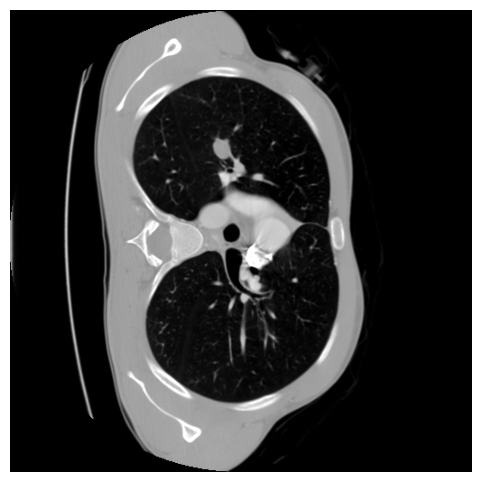

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,6), frameon=False)
ax.imshow(img, cmap='gray')
ax.axis('off')

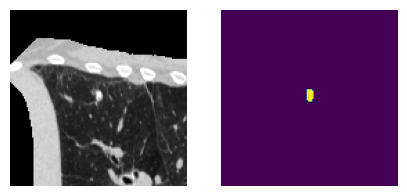

In [26]:

points_sampler = MultiPointSampler(
        24,
        prob_gamma=0.80,
        merge_objects_prob=0.15,
        max_num_merged_objects=2,
        use_hierarchy=False,
        first_click_center=True,
    )

preprocess_cfg = {
    'enhancements': {
        },
    'normalize': False,
    'windowing': {
        'enabled': False,
        'min': -1000,
        'max': 400,
    },
    'convert_to_rgb': False
}

preprocessor = Preprocessor(preprocess_cfg)

dataset = utils.get_dataset('LIDC_CROPS_TEST', cfg, preprocessor=preprocessor)
dataset.points_sampler = points_sampler
loader = DataLoader(
            dataset,
            5,
            sampler=get_sampler(dataset, shuffle=False, distributed=False),
            drop_last=True,
            pin_memory=True,
            num_workers=0,
        )
loader_iter = iter(loader)
batch = next(loader_iter)
visualise_batch(batch)

In [28]:
dataset = utils.get_dataset('LIDC_CROPS_WHITENED_TEST', cfg)
mask_sizes = [np.sum(dataset.get_sample(i).gt_mask) for i in range(len(dataset))]
print(f'Mean mask size: {np.mean(mask_sizes)}, max mask size: {np.max(mask_sizes)}, min mask size: {np.min(mask_sizes)}')
mask_pixel_count = dataset.get_sample(0).gt_mask.shape[0] * dataset.get_sample(0).gt_mask.shape[1]
mask_percentages = [mask_size / mask_pixel_count for mask_size in mask_sizes]
print(f'Mean mask percentage: {np.mean(mask_percentages)}, max mask percentage: {np.max(mask_percentages)}, min mask percentage: {np.min(mask_percentages)}')
print(f'Samples with mask bigger than 10 pixels {np.sum(np.array(mask_sizes) > 10)}')

Mean mask size: 82.61225478324049, max mask size: 980, min mask size: 1
Mean mask percentage: 0.005042251878859893, max mask percentage: 0.059814453125, min mask percentage: 6.103515625e-05
Samples with mask bigger than 10 pixels 3309


In [29]:
print(f'Samples bigger than 20 pixels {np.sum(np.array(mask_sizes) > 20)}')

Samples bigger than 20 pixels 2649


In [30]:
print(f'Samples which are at least one percent mask {np.sum(np.array(mask_percentages) > 0.01)}')

Samples which are at least one percent mask 594


Mean mask size: 127.47735529183822, max mask size: 2040, min mask size: 1
Mean mask percentage: 0.00778060029857411, max mask percentage: 0.12451171875, min mask percentage: 6.103515625e-05


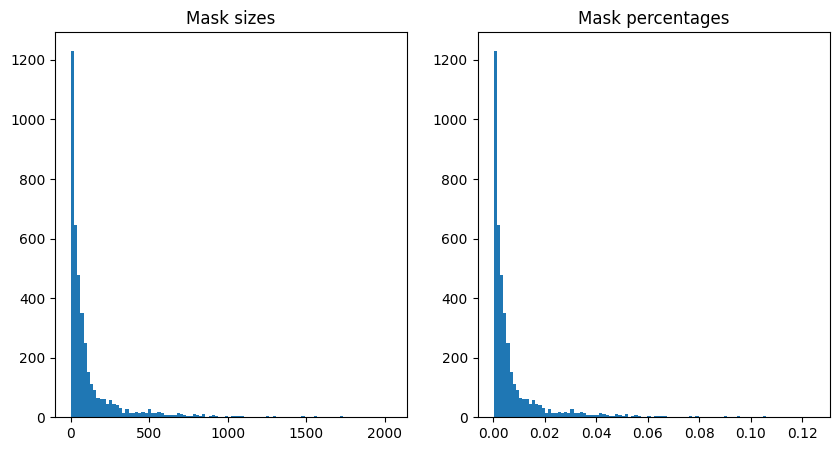

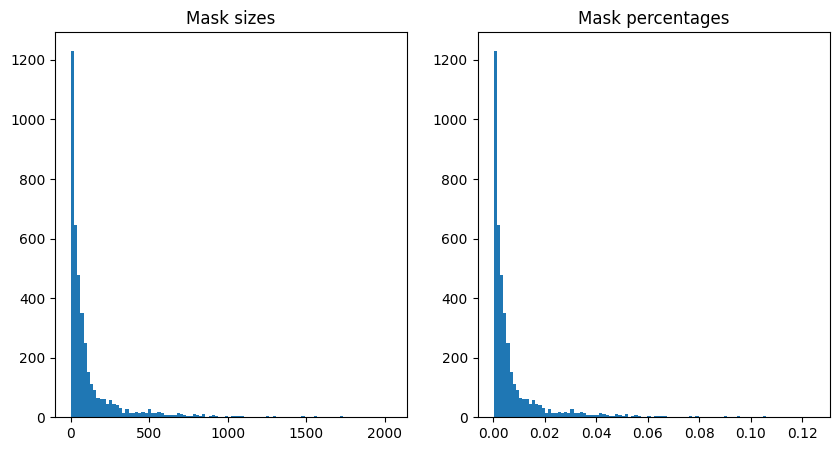

In [25]:
def show_dataset_mask_distribution(dataset_name):
    dataset = utils.get_dataset(dataset_name, cfg)
    mask_sizes = [np.sum(dataset.get_sample(i).gt_mask) for i in range(len(dataset))]
    print(f'Mean mask size: {np.mean(mask_sizes)}, max mask size: {np.max(mask_sizes)}, min mask size: {np.min(mask_sizes)}')
    mask_pixel_count = dataset.get_sample(0).gt_mask.shape[0] * dataset.get_sample(0).gt_mask.shape[1]
    mask_percentages = [mask_size / mask_pixel_count for mask_size in mask_sizes]
    print(f'Mean mask percentage: {np.mean(mask_percentages)}, max mask percentage: {np.max(mask_percentages)}, min mask percentage: {np.min(mask_percentages)}')
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].hist(mask_sizes, bins=100)
    ax[0].set_title('Mask sizes')
    ax[1].hist(mask_percentages, bins=100)
    ax[1].set_title('Mask percentages')
    return fig

show_dataset_mask_distribution('LIDC_CROPS_BOXED_TEST')

Mean mask size: 82.61225478324049, max mask size: 980, min mask size: 1
Mean mask percentage: 0.005042251878859893, max mask percentage: 0.059814453125, min mask percentage: 6.103515625e-05


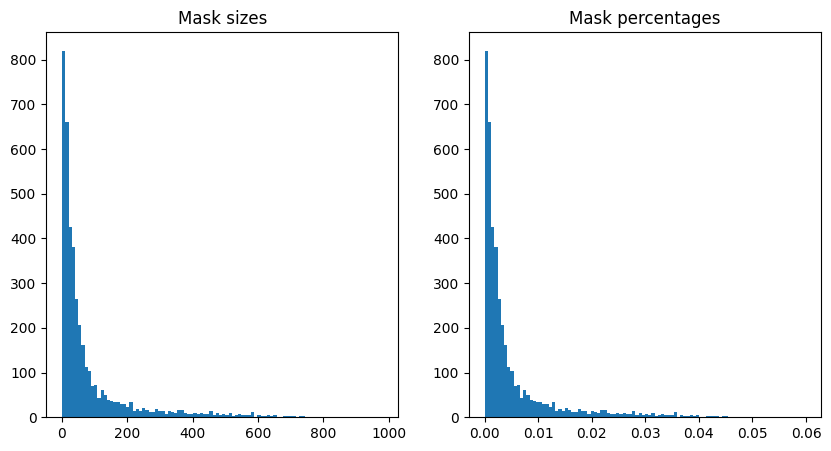

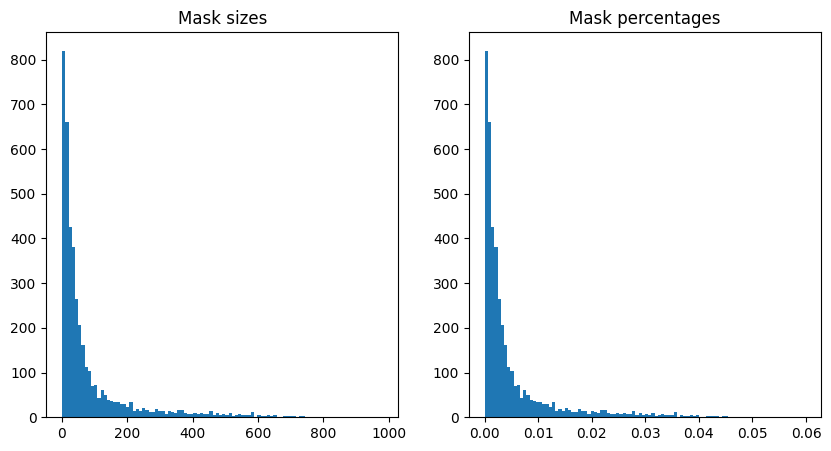

In [27]:
show_dataset_mask_distribution('LIDC_CROPS_TEST')

Mean mask size: 235.8181818181818, max mask size: 1724, min mask size: 24
Mean mask percentage: 0.0008995749733664773, max mask percentage: 0.0065765380859375, min mask percentage: 9.1552734375e-05


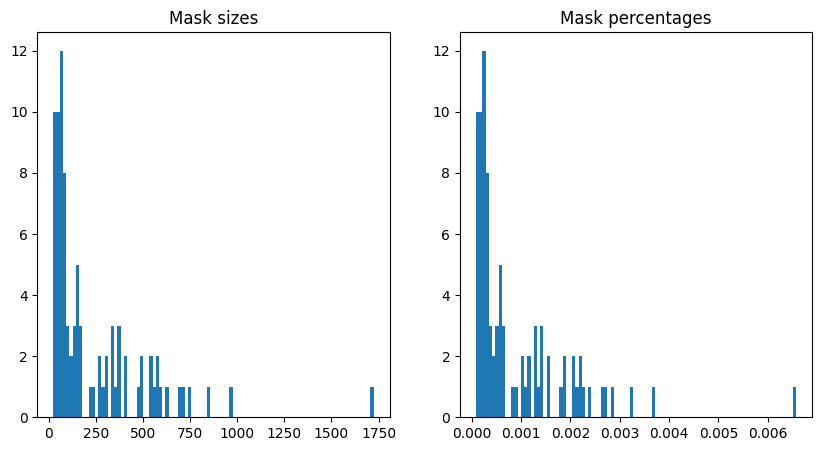

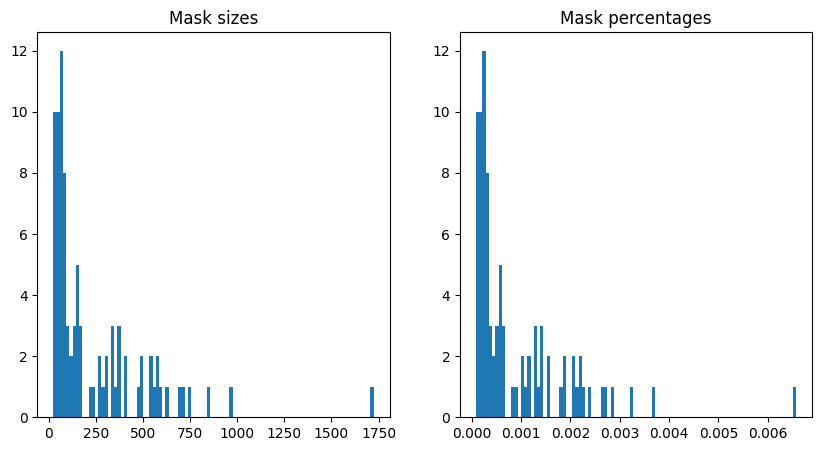

In [26]:
show_dataset_mask_distribution('LIDC_2D_VAL')

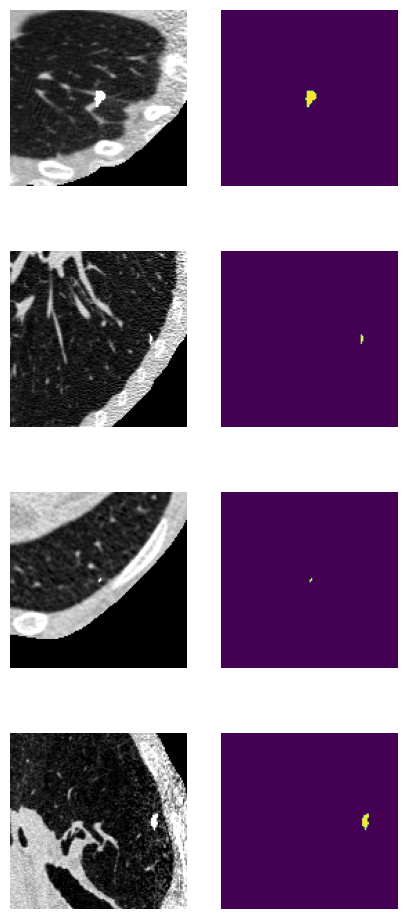

In [42]:
points_sampler = MultiPointSampler(
        24,
        prob_gamma=0.80,
        merge_objects_prob=0.15,
        max_num_merged_objects=2,
        use_hierarchy=False,
        first_click_center=True,
    )

preprocess_cfg = {
    'enhancements': {
        },
    'normalize': False,
    'windowing': {
        'enabled': False,
        'min': -1000,
        'max': 400,
    },
    'convert_to_rgb': False
}

preprocessor = Preprocessor(preprocess_cfg)

dataset = utils.get_dataset('LIDC_CROPS_WHITENED_TEST', cfg, preprocessor=preprocessor)
dataset.points_sampler = points_sampler
loader = DataLoader(
            dataset,
            4,
            sampler=get_sampler(dataset, shuffle=True, distributed=False),
            drop_last=True,
            pin_memory=True,
            num_workers=0,
        )
batch = next(iter(loader))
visualise_batch(batch)


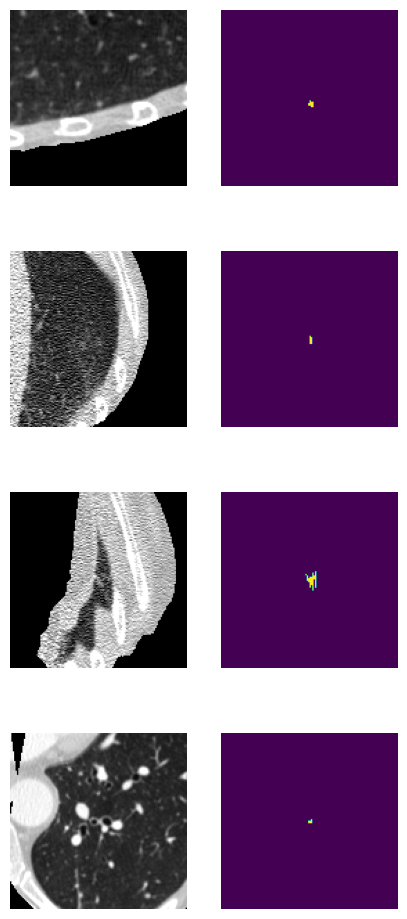

In [43]:
points_sampler = MultiPointSampler(
        24,
        prob_gamma=0.80,
        merge_objects_prob=0.15,
        max_num_merged_objects=2,
        use_hierarchy=False,
        first_click_center=True,
    )

preprocess_cfg = {
    'enhancements': {
        },
    'normalize': False,
    'windowing': {
        'enabled': False,
        'min': -1000,
        'max': 400,
    },
    'convert_to_rgb': False
}

preprocessor = Preprocessor(preprocess_cfg)

dataset = utils.get_dataset('LIDC_CROPS_TEST', cfg, preprocessor=preprocessor)
dataset.points_sampler = points_sampler
loader = DataLoader(
            dataset,
            4,
            sampler=get_sampler(dataset, shuffle=True, distributed=False),
            drop_last=True,
            pin_memory=True,
            num_workers=0,
        )
batch = next(iter(loader))
visualise_batch(batch)